# 2.2.2  ランキングにおけるIPS推定量

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.utils import check_random_state
plt.style.use('ggplot')
y_label_dict = {"se": "左図：平均二乗誤差", "bias": "中図：二乗バイアス", "variance": "右図：バリアンス"}

from dataset import generate_synthetic_data, calc_true_value
from estimators import calc_avg, calc_ips
from utils import eps_greedy_policy, aggregate_simulation_results

### ランキングの長さ$K$を変化させたときのAVG・IPS推定量の平均二乗誤差・二乗バイアス・バリアンスの挙動

In [2]:
## シミュレーション設定
num_runs = 1000 # シミュレーションの繰り返し回数
dim_context = 5 # 特徴量xの次元
num_data = 2000 # ログデータのサイズ
num_actions = 4 # ユニークなアイテム数
beta = 1 # データ収集方策のパラメータ
p = [0, 0, 1] # ユーザ行動の出現割合, (独立モデル, カスケードモデル, 全依存モデル)
random_state = 12345
K_list = [4, 6, 8, 10, 12, 14] # ランキングの長さ

In [3]:
result_df_list = []
for K in K_list:
    ## 評価方策の真の性能(policy value)を計算
    random_ = check_random_state(random_state)
    theta = random_.normal(size=(dim_context, num_actions))
    M = random_.normal(size=(dim_context, num_actions))
    b = random_.normal(size=(1, num_actions))
    W = random_.uniform(0, 1, size=(K, K))
    policy_value = calc_true_value(
        dim_context=dim_context, num_actions=num_actions,
        theta=theta, M=M, b=b, W=W, K=K, p=p,
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"K={K}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data  = generate_synthetic_data(
            num_data=num_data, dim_context=dim_context, num_actions=num_actions,
            theta=theta, M=M, b=b, W=W, K=K, p=p, beta=beta, random_state=_
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data ["base_q_func"])

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["avg"] = calc_avg(offline_logged_data , pi)
        estimated_policy_values["ips"] = calc_ips(offline_logged_data , pi)
        estimated_policy_value_list.append(estimated_policy_values)

    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "K", K,
        )
    )
result_df_k = pd.concat(result_df_list).reset_index(level=0)


K=14...: 100%|██████████| 1000/1000 [01:07<00:00, 14.80it/s]


## 図2.6

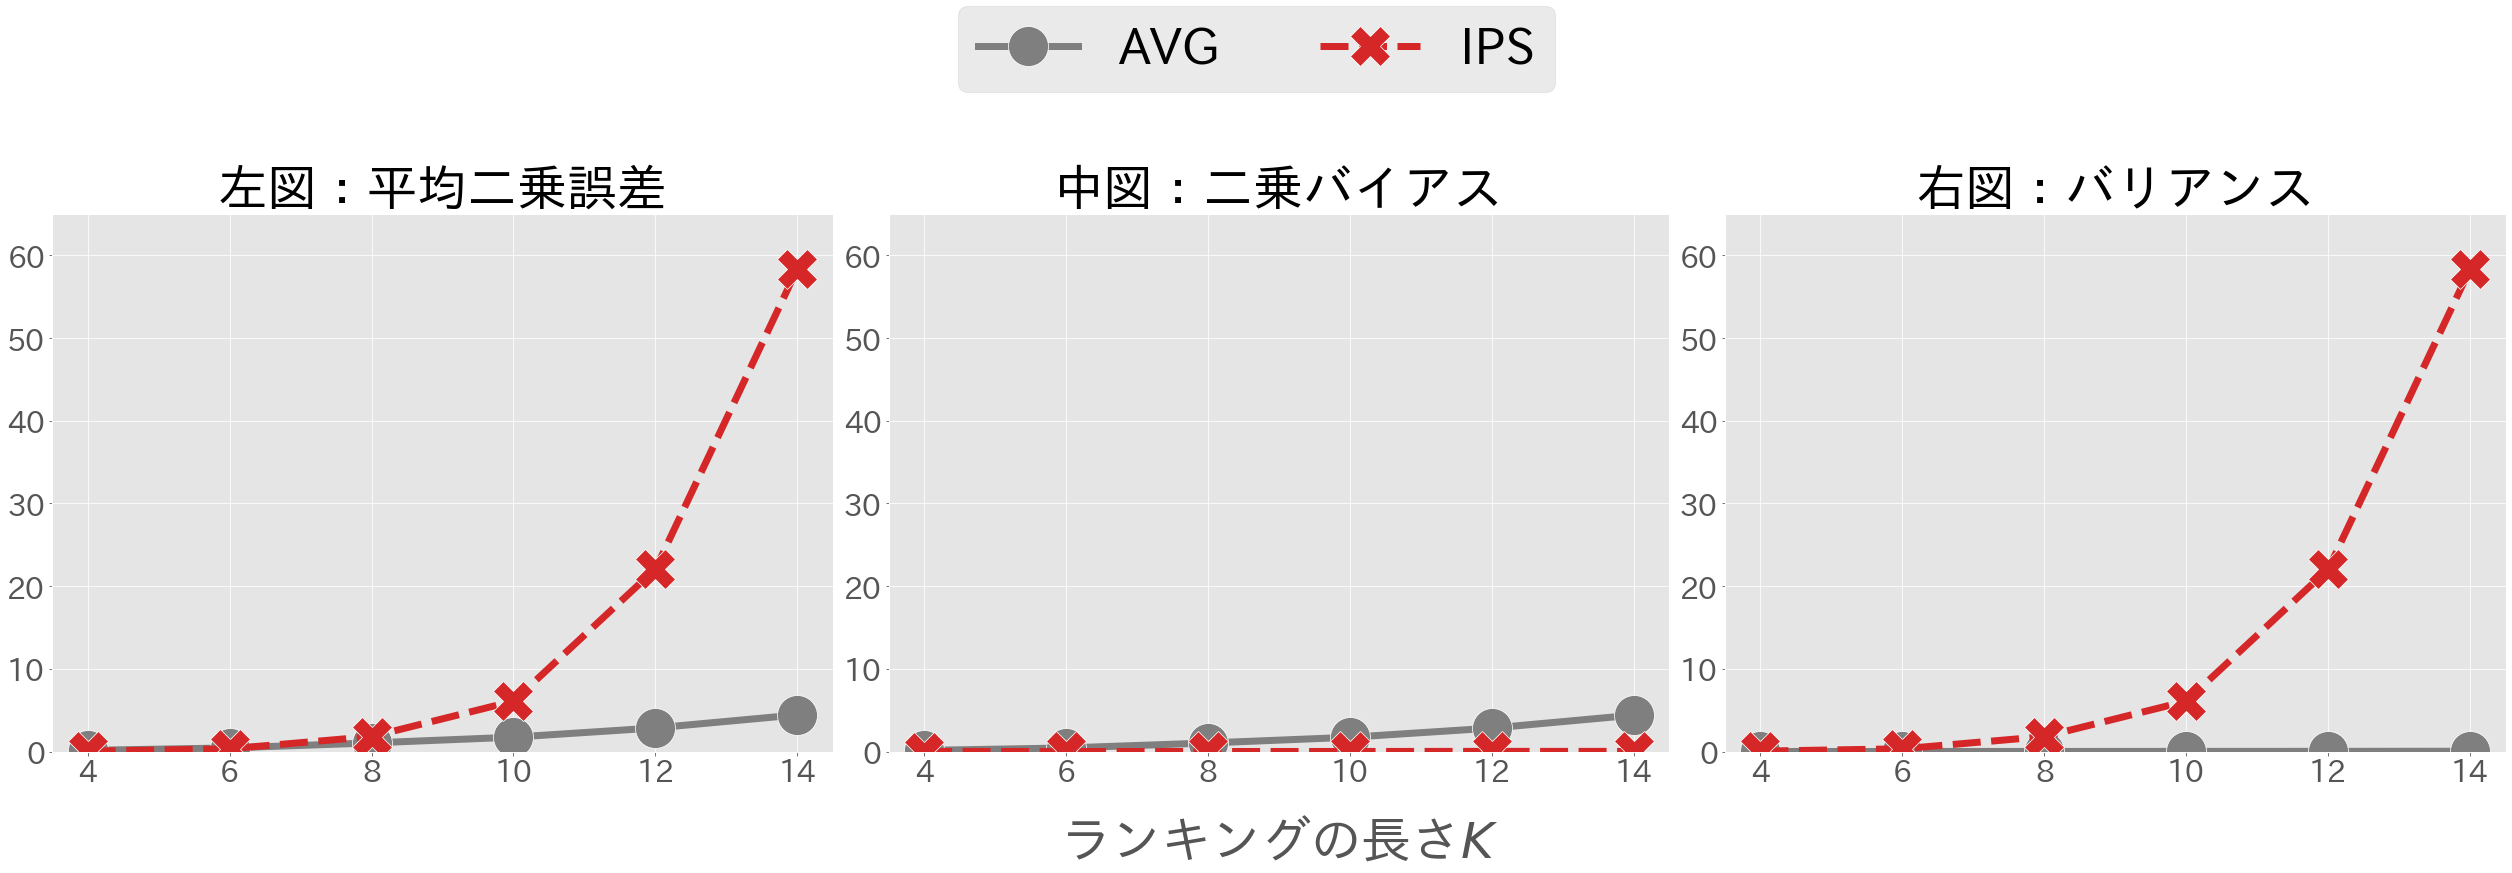

In [4]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="K",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:grey", "tab:red"],
        data=result_df_k.query("est == 'ips' or est == 'avg'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 65)
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    if i == 1:
        ax.set_xlabel(r"ランキングの長さ$K$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(K_list)
    ax.set_xticklabels(K_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["AVG", "IPS"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=5, loc="center")


### ログデータのサイズ$n$を変化させたときのAVG・IPS推定量の平均二乗誤差・二乗バイアス・バリアンスの挙動

In [6]:
## シミュレーション設定
num_runs = 1000 # シミュレーションの繰り返し回数
dim_context = 5 # 特徴量xの次元
K = 8 # ランキングの長さ
num_actions = 4 # ユニークなアイテム数
beta = 1 # データ収集方策のパラメータ
p = [0, 0, 1] # ユーザ行動の出現割合, (独立モデル, カスケードモデル, 全依存モデル)
random_state = 12345
num_data_list = [500, 1000, 2000, 4000, 8000] # ログデータのサイズ


In [7]:
result_df_list = []
for num_data in num_data_list:
    ## 評価方策の真の性能(policy value)を計算
    random_ = check_random_state(random_state)
    theta = random_.normal(size=(dim_context, num_actions))
    M = random_.normal(size=(dim_context, num_actions))
    b = random_.normal(size=(1, num_actions))
    W = random_.uniform(0, 1, size=(K, K))
    policy_value = calc_true_value(
        dim_context=dim_context, num_actions=num_actions,
        theta=theta, M=M, b=b, W=W, K=K, p=p,
    )

    estimated_policy_value_list = []
    for _ in tqdm(range(num_runs), desc=f"num_data={num_data}..."):
        ## データ収集方策が形成する分布に従いログデータを生成
        offline_logged_data = generate_synthetic_data(
            num_data=num_data, dim_context=dim_context, num_actions=num_actions,
            theta=theta, M=M, b=b, W=W, K=K, p=p, beta=beta, random_state=_
        )

        ## ログデータ上における評価方策の行動選択確率を計算
        pi = eps_greedy_policy(offline_logged_data["base_q_func"])

        ## ログデータを用いてオフ方策評価を実行する
        estimated_policy_values = dict()
        estimated_policy_values["avg"] = calc_avg(offline_logged_data, pi)
        estimated_policy_values["ips"] = calc_ips(offline_logged_data, pi)
        estimated_policy_value_list.append(estimated_policy_values)


    ## シミュレーション結果を集計する
    result_df_list.append(
        aggregate_simulation_results(
            estimated_policy_value_list, policy_value, "num_data", num_data,
        )
    )
result_df_data = pd.concat(result_df_list).reset_index(level=0)

num_data=8000...: 100%|██████████| 1000/1000 [03:43<00:00,  4.48it/s]


## 図2.7

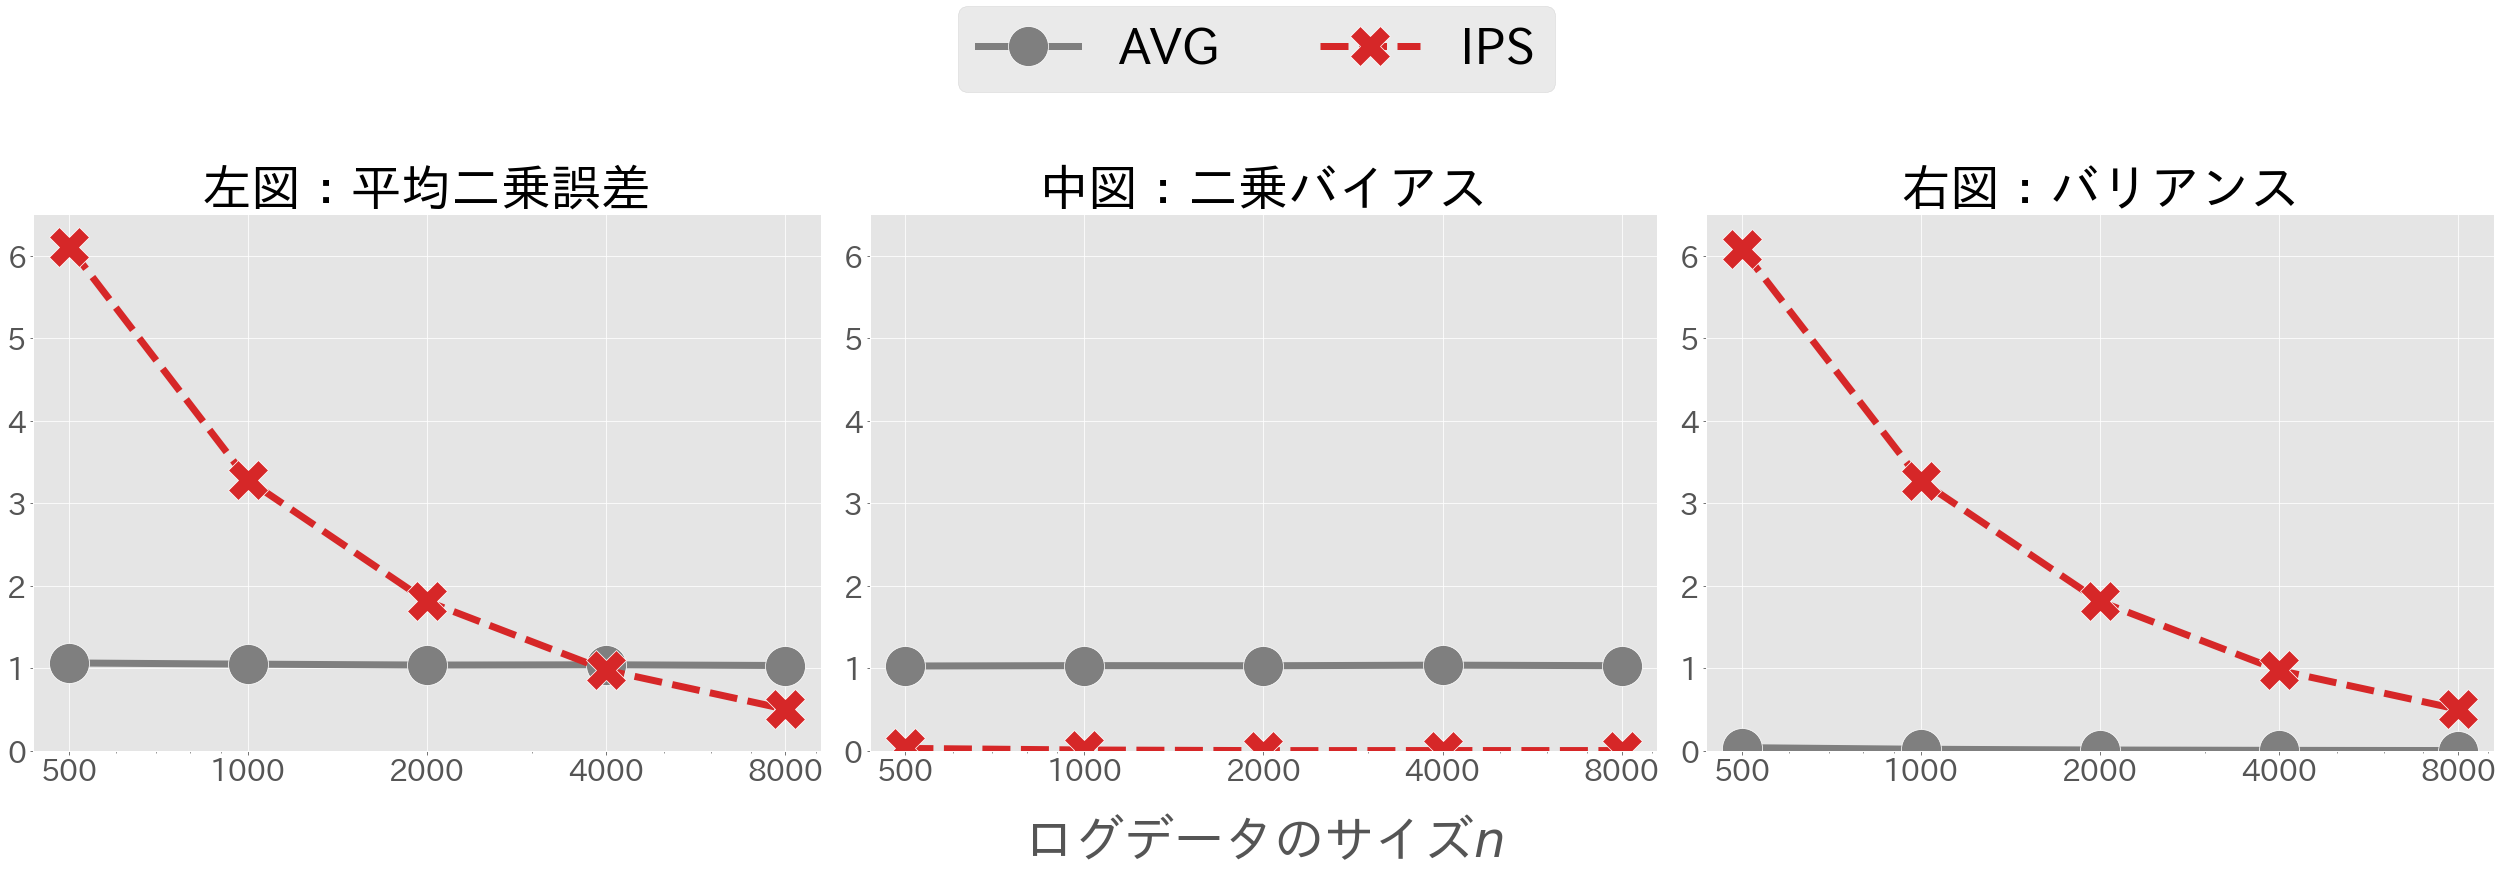

In [11]:
fig, ax_list = plt.subplots(1, 3, figsize=(35, 10), tight_layout=True)
for i, y in enumerate(["se", "bias", "variance"]):
    ax = ax_list[i]
    sns.lineplot(
        markers=True,
        markersize=40,
        linewidth=7,
        legend=False,
        style="est",
        x="num_data",
        y=y,
        hue="est",
        ax=ax,
        ci=None,
        palette=["tab:grey", "tab:red"],
        data=result_df_data.query("est == 'ips' or est == 'avg'"),
    )
    ax.set_title(y_label_dict[y], fontsize=50)
    # yaxis
    ax.set_ylabel("")
    ax.set_ylim(0.0, 6.5)
    ax.tick_params(axis="y", labelsize=30)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    # xaxis
    ax.set_xscale("log")
    if i == 1:
        ax.set_xlabel(r"ログデータのサイズ$n$", fontsize=50)
    else:
        ax.set_xlabel(r"", fontsize=40)
    ax.set_xticks(num_data_list)
    ax.set_xticklabels(num_data_list, fontsize=30)
    ax.xaxis.set_label_coords(0.5, -0.12)
fig.legend(["AVG", "IPS"], fontsize=50, bbox_to_anchor=(0.5, 1.15), ncol=5, loc="center")
